# Import modules

In [77]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np
import re
import math

# Open dataset

In [3]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### Info per atributte

In [4]:
#We can observe the attributes with missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


### Name attributes

In [5]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

# Type

## plot type

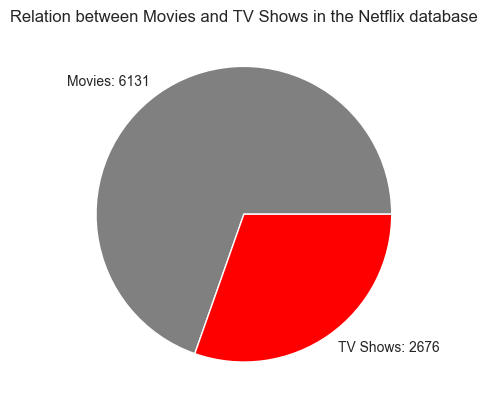

In [6]:
type_ = df['type'].value_counts()
plt.pie(type_,
        labels = ['Movies: ' + str(type_[0]),
                  'TV Shows: ' + str(type_[1])],
        colors = ['gray', 'red'])
plt.title('Relation between Movies and TV Shows in the Netflix database')
plt.show()

## type distribution per country

In [7]:
#Ad we can see, the item 7 as several countries associated, in following cells we gonna unpack them
df[['type','country']].head(10)

,type,country
0,Movie,United States
1,TV Show,South Africa
2,TV Show,NaN
3,TV Show,NaN
4,TV Show,India
5,TV Show,NaN
6,Movie,NaN
7,Movie,"United States, Ghana, Burkina Faso, United Kin..."
8,TV Show,United Kingdom
9,Movie,United States


In [8]:
# Clean data i.e. remove white spaces and make lowercases
df['country'] = df['country'].str.lower()
df['country'] = df['country'].replace(' ', '', regex=True)
types, countries = [], []
for i in range(len(df['country'])):
    # if not str i.e. nan
    if not isinstance(df['country'][i], str):
        #print(0)
        pass
    else:
        #unpack the movies/series with several countries
        if ',' in df['country'][i]:
            l = len(df['country'][i].split(','))
            types.extend([df['type'][i]]*l)
            countries.extend(df['country'][i].split(','))
        else:
            types.append(df['type'][i])
            countries.append(df['country'][i])

In [9]:
#attribute unpacked
df_types_countries = pd.DataFrame({'type' : types, 'country' : countries})
df_types_countries.head()

,type,country
0,Movie,unitedstates
1,TV Show,southafrica
2,TV Show,india
3,Movie,unitedstates
4,Movie,ghana


In [10]:
# Filter the data to specific countries and group it by the type of content
interest_countries = ['unitedstates', 'india', 'unitedkingdom', 'canada', 'france', 'japan', 'spain', 'mexico']
df_types_countries_filtered = df_types_countries.query(("country in @interest_countries"))
df_grouped_type = df_types_countries_filtered.groupby(['country', 'type']).size().reset_index(name='count')
df_grouped_type.head(6)

,country,type,count
0,canada,Movie,319
1,canada,TV Show,126
2,france,Movie,303
3,france,TV Show,90
4,india,Movie,962
5,india,TV Show,84


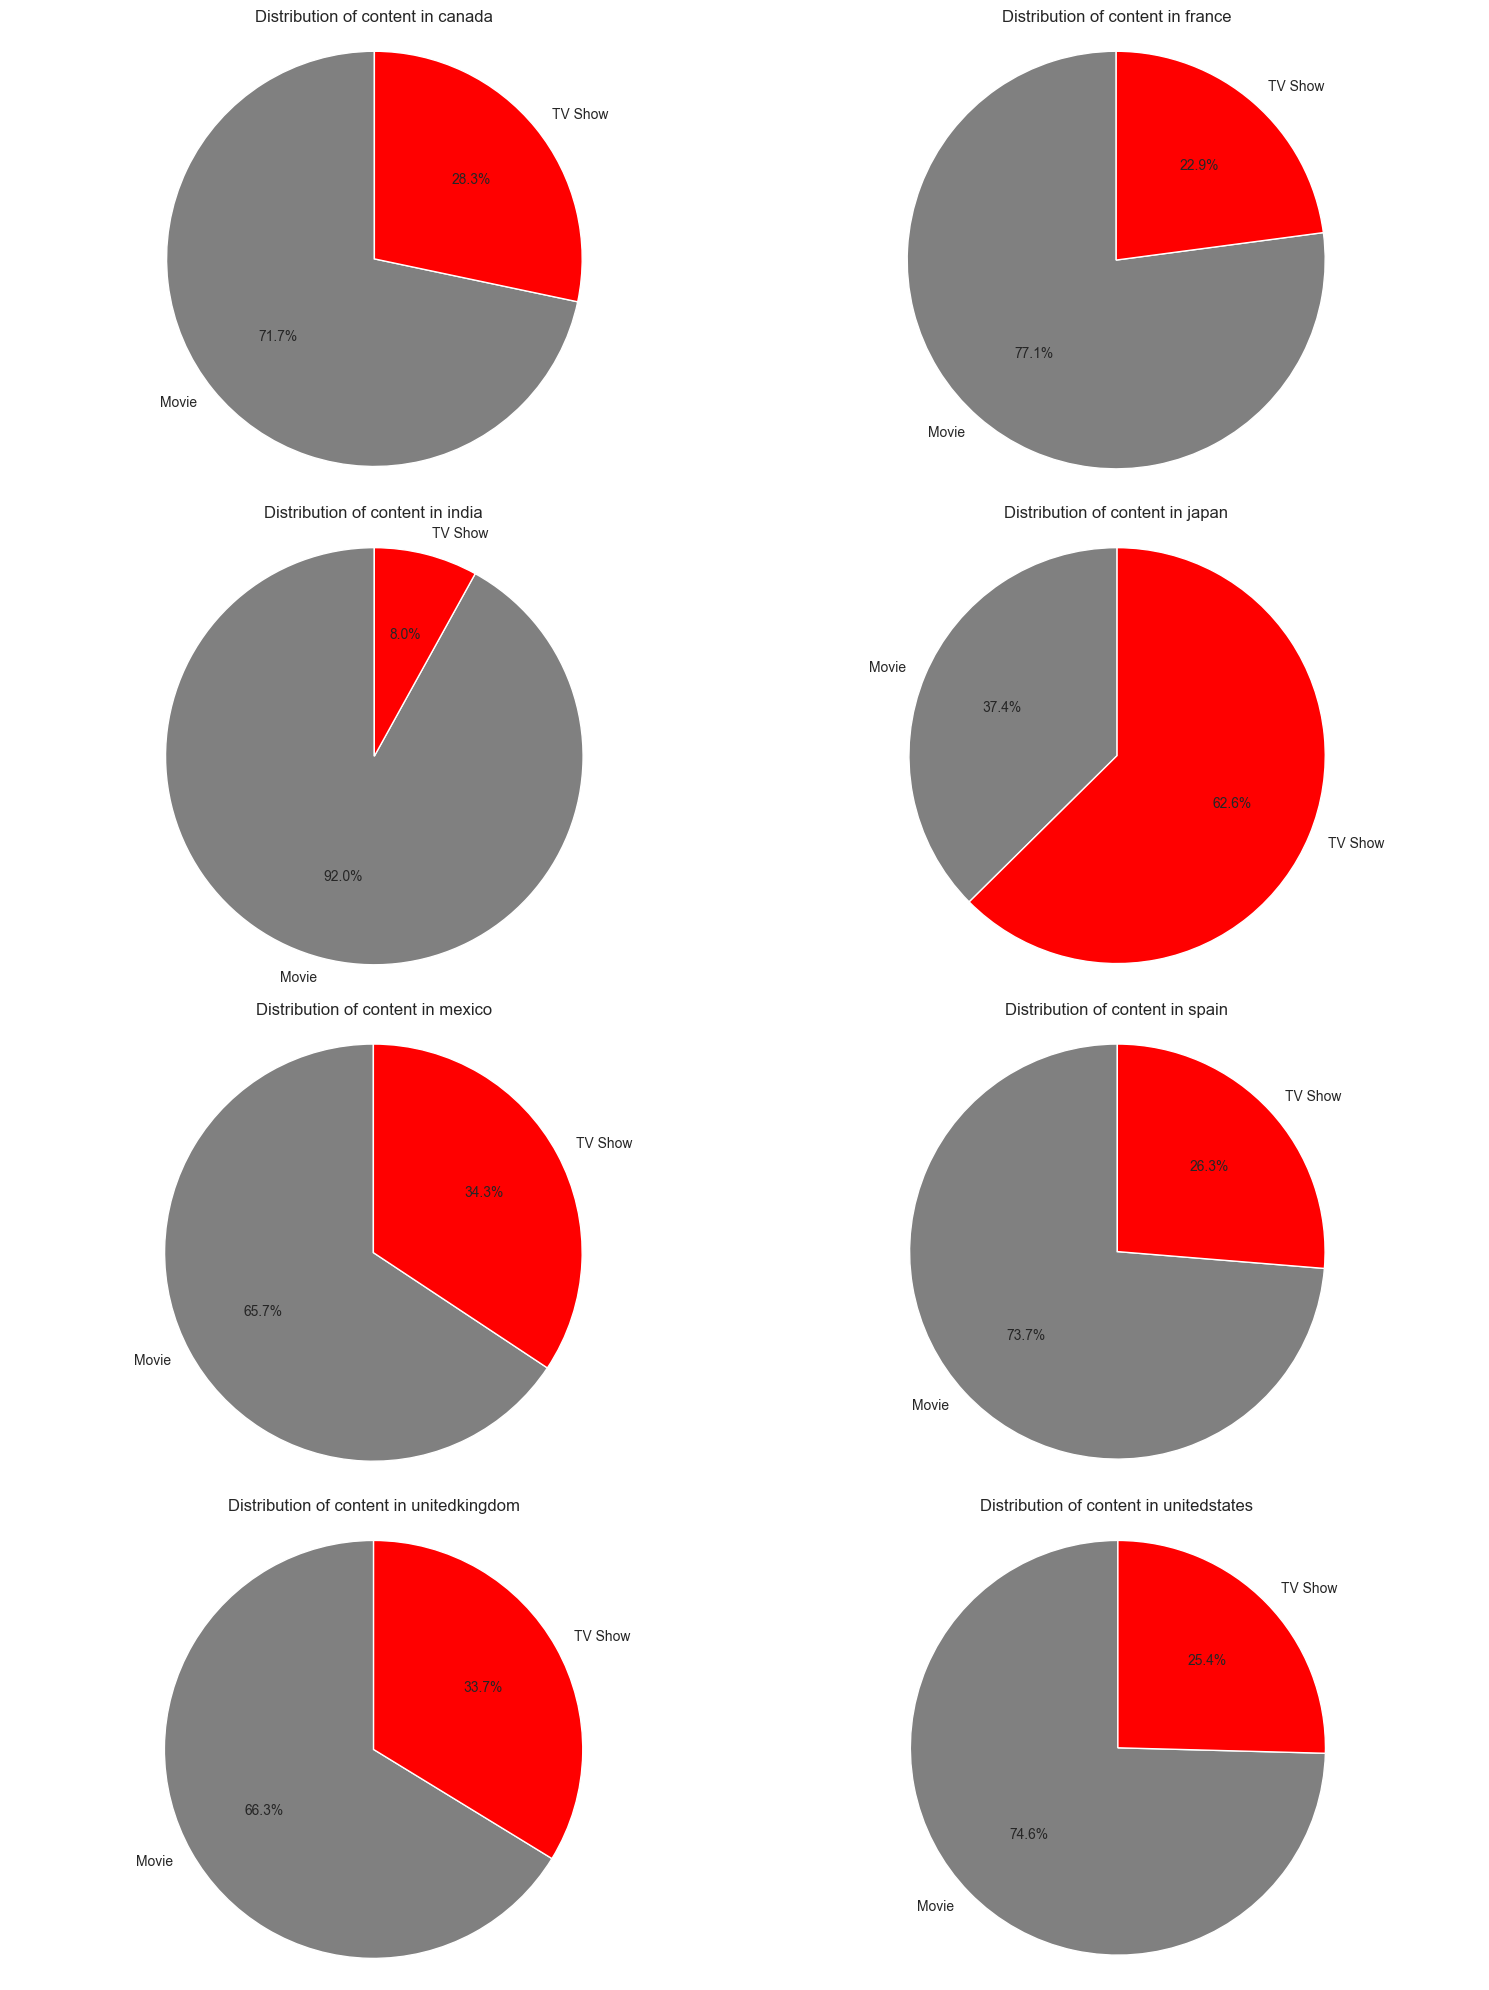

In [11]:
#Pie charts for the interest countries and its content
# Get unique countries
unique_countries = df_grouped_type['country'].unique()

num_rows = 4
num_cols = 2

# Create a grid of pie charts
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20))

# Flatten the axis array for easy iteration
axs = axs.ravel()

for i, country in enumerate(unique_countries):
    if i < num_rows * num_cols:
        country_data = df_grouped_type[df_grouped_type['country'] == country]
        axs[i].pie(country_data['count'], labels=country_data['type'], autopct='%1.1f%%', startangle=90,
                    colors = ['gray', 'red'])
        axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        axs[i].set_title(f'Distribution of content in {country}')

# Hide remaining empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# Director

In [12]:
#Displaying the top 15 directors, remember that this attribute is the one with most empty values 
director = df['director'].value_counts()
director.head(15)

Rajiv Chilaka             19
Raúl Campos, Jan Suter    18
Marcus Raboy              16
Suhas Kadav               16
Jay Karas                 14
Cathy Garcia-Molina       13
Martin Scorsese           12
Youssef Chahine           12
Jay Chapman               12
Steven Spielberg          11
Don Michael Paul          10
David Dhawan               9
Yılmaz Erdoğan             8
Lance Bangs                8
Kunle Afolayan             8
Name: director, dtype: int64

## plot directors

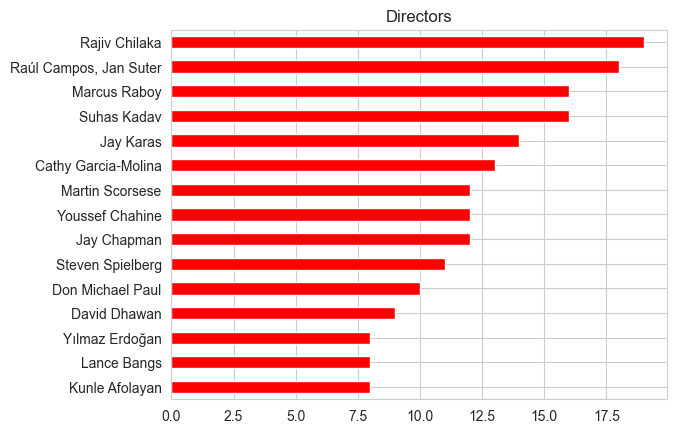

In [13]:
director[:15].plot(x = 'director', y = '', kind = 'barh', title='Directors', color = 'red').invert_yaxis()
plt.show()

# Cast

In [14]:
cast = df['cast']
cast[:5]

0                                                  NaN
1    Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...
2    Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...
3                                                  NaN
4    Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...
Name: cast, dtype: object

In [15]:
#There are several artist per Movie/TVShow, so we unpack them
cast = [c.split(',') for c in cast if isinstance(c, str)]
cast[:2]

[['Ama Qamata',
  ' Khosi Ngema',
  ' Gail Mabalane',
  ' Thabang Molaba',
  ' Dillon Windvogel',
  ' Natasha Thahane',
  ' Arno Greeff',
  ' Xolile Tshabalala',
  ' Getmore Sithole',
  ' Cindy Mahlangu',
  ' Ryle De Morny',
  ' Greteli Fincham',
  ' Sello Maake Ka-Ncube',
  ' Odwa Gwanya',
  ' Mekaila Mathys',
  ' Sandi Schultz',
  ' Duane Williams',
  ' Shamilla Miller',
  ' Patrick Mofokeng'],
 ['Sami Bouajila',
  ' Tracy Gotoas',
  ' Samuel Jouy',
  ' Nabiha Akkari',
  ' Sofia Lesaffre',
  ' Salim Kechiouche',
  ' Noureddine Farihi',
  ' Geert Van Rampelberg',
  ' Bakary Diombera']]

In [16]:
merged_cast = []
for c in cast:
  merged_cast.extend(c)
merged_cast[:5]

['Ama Qamata',
 ' Khosi Ngema',
 ' Gail Mabalane',
 ' Thabang Molaba',
 ' Dillon Windvogel']

## plot cast

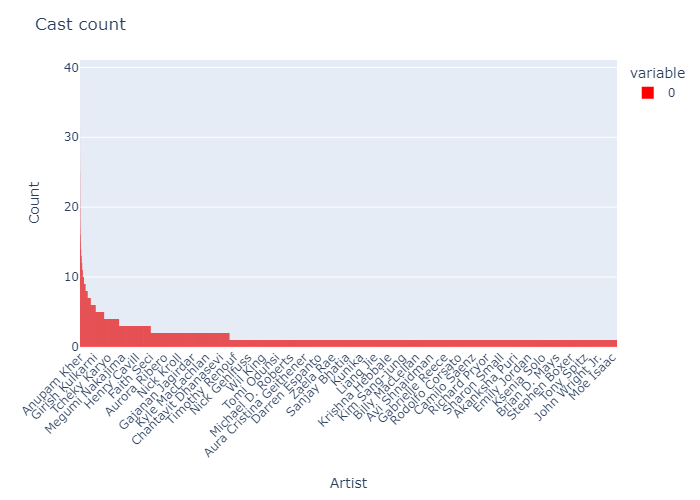

In [26]:
from plotly.express import histogram

fig = histogram(merged_cast, color_discrete_sequence = ['red']).update_xaxes(categoryorder='total descending')
fig.update_layout(title = 'Cast Histogram')
fig.update_layout(title='Cast count', xaxis_title='Artist', yaxis_title='Count')
fig.update_layout(xaxis_tickangle=-45)
fig.show('png') #specify 'png' to ensure display on github, if you run in notebook remove parameter to have an interactive plot

## Cast per country

# Country

In [18]:
df['country'].value_counts()[:5]

unitedstates     2818
india             972
unitedkingdom     419
japan             245
southkorea        199
Name: country, dtype: int64

In [19]:
#df['country'] = df['country'].str.lower()
#df['country'] = df['country'].replace(' ', '', regex=True)
#df['country'].head()

In [20]:
#As wa can observe, there are several countries for som items
country = df['country']
country = [c.split(',') for c in country if isinstance(c, str)]
country[:5]

[['unitedstates'],
 ['southafrica'],
 ['india'],
 ['unitedstates',
  'ghana',
  'burkinafaso',
  'unitedkingdom',
  'germany',
  'ethiopia'],
 ['unitedkingdom']]

In [21]:
#We unpack those items
countries = []
for c in country:
  countries.extend(c)
#for i in range(len(countries)):
#    countries[i] = countries[i].replace(' ', '')

In [22]:
#When we unpack we have more information
len(df['country']), len(countries)

(8807, 10019)

In [23]:
#Count the times a country appear
counts_countries = Counter(countries)
counter_df = pd.DataFrame(list(counts_countries.items()), columns=['countries', 'counts'])
counter_df_sorted = counter_df.sort_values(by='counts', ascending=False).reset_index(drop=True)
counter_df_sorted.head()

,countries,counts
0,unitedstates,3690
1,india,1046
2,unitedkingdom,806
3,canada,445
4,france,393


## plot count countrys

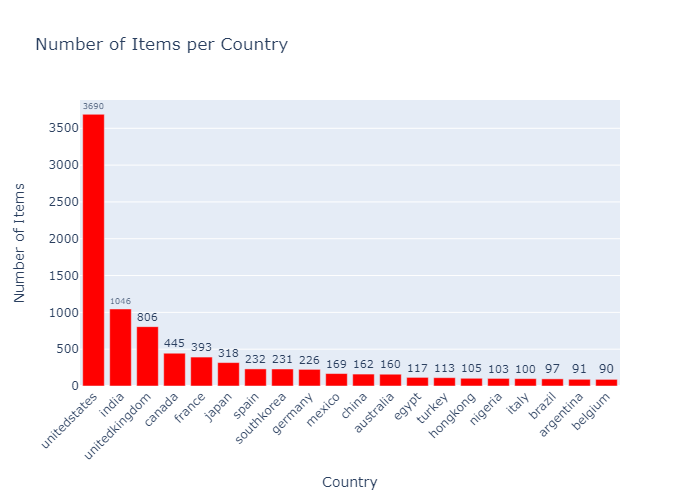

In [27]:
import plotly.graph_objects as go

top_N_countries = 20
top_countries = counter_df_sorted['countries'][:top_N_countries]
top_values = counter_df_sorted['counts'][:top_N_countries]

fig = go.Figure([go.Bar(x=top_countries, y=top_values, marker = dict(color = 'red'))])

fig.update_traces(texttemplate='%{y}', textposition='outside')

fig.update_layout(title='Number of Items per Country', xaxis_title='Country', yaxis_title='Number of Items')
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability

fig.show('png') #specify 'png' to ensure display on github, if you run in notebook remove parameter to have an interactive plot

# Date added

## Date added per movie and TV Shows

In [189]:
date_added_Movies, date_added_TV_shows = [], []
for i in range(len(df)):
  if df['type'].iloc[i] == 'Movie' and isinstance(df['date_added'].iloc[i], str):
    try:
      date_added_Movies.append(df['date_added'].iloc[i].split(' ')[0] + df['date_added'].iloc[i].split(',')[1][-5:])
    except:
      pass
  elif df['type'].iloc[i] == 'TV Show' and isinstance(df['date_added'].iloc[i], str):
    try:
      date_added_TV_shows.append(df['date_added'].iloc[i].split(' ')[0] + df['date_added'].iloc[i].split(',')[1][-5:])
    except:
      pass

In [190]:
count_date_added_Movies, count_date_added_TV_shows = Counter(date_added_Movies), Counter(date_added_TV_shows)

## plot date added per movie and TV Shows

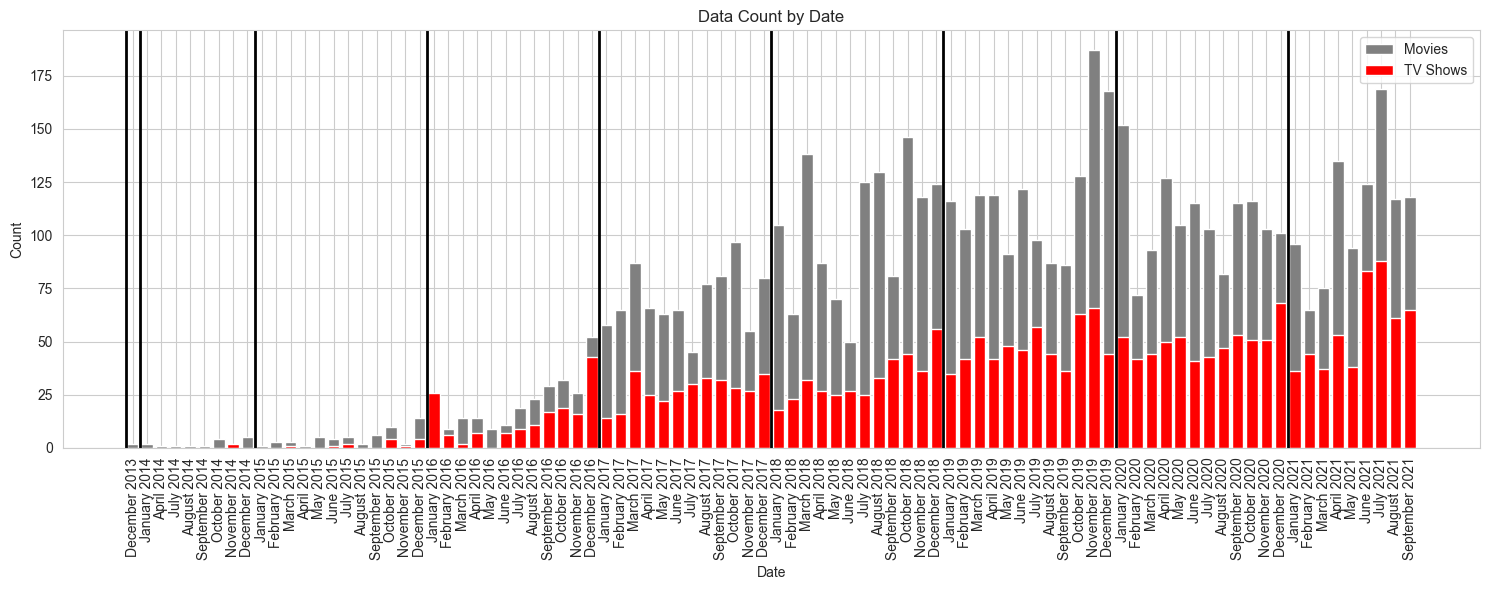

In [191]:
dates_movies = list(count_date_added_Movies.keys())[:-15]
values_movies = list(count_date_added_Movies.values())[:-15]
dates_TVShows = list(count_date_added_TV_shows.keys())[:-17]
values_TVShows = list(count_date_added_TV_shows.values())[:-17]

plt.figure(figsize=(15, 6))
plt.bar(dates_movies[::-1], values_movies[::-1], label = 'Movies', color = 'gray')
plt.bar(dates_TVShows[::-1], values_TVShows[::-1], label = 'TV Shows', color = 'red')


plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Data Count by Date')
plt.xticks(rotation=90)

# Adding division lines for each new year
prev_year = 2008
for i, Date in enumerate(dates_movies[::-1]):
  year = Date.split(' ')[1]
  if year != prev_year:
    plt.axvline(x=i-.5, color='k', linestyle='-', linewidth=2)
    prev_year = year
plt.legend()
plt.tight_layout()
plt.show()

# Release_year

In [29]:
release_year = df['release_year']
release_year = Counter(release_year)
release_year = dict(sorted(release_year.items(), reverse=True))
list(release_year.items())[:5] #displaying the first elements

[(2021, 592), (2020, 953), (2019, 1030), (2018, 1147), (2017, 1032)]

## plot release year

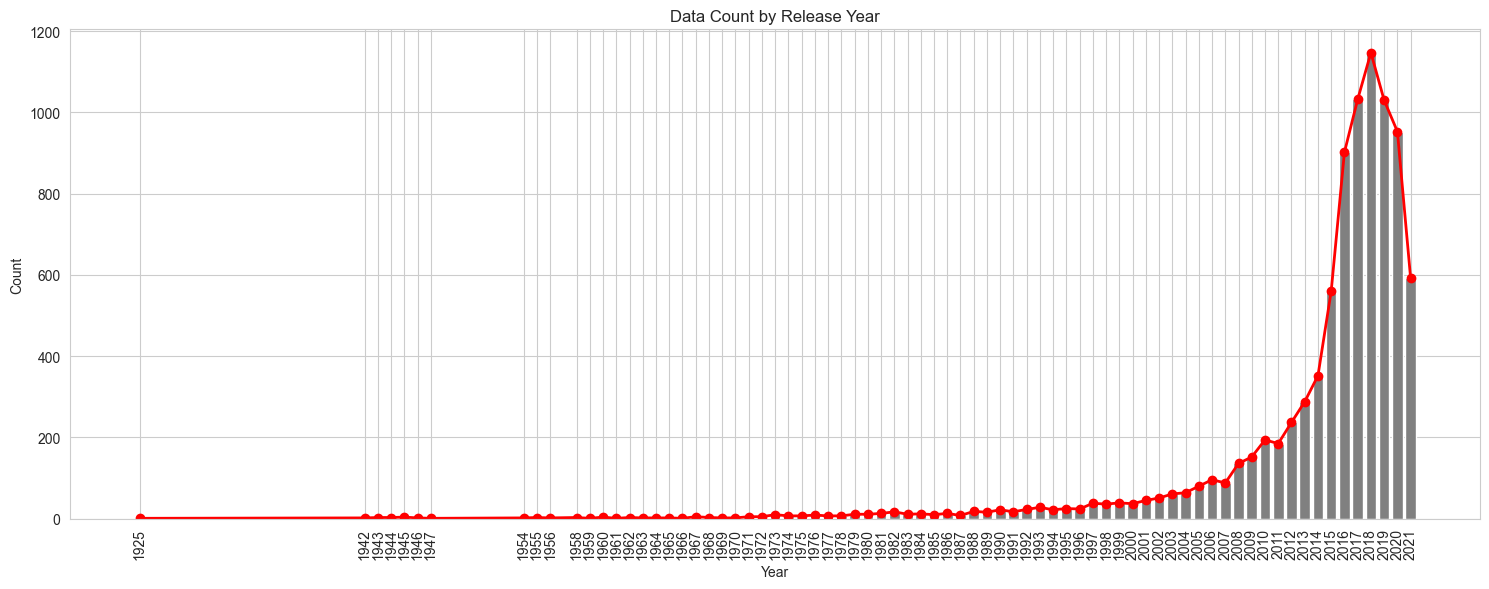

In [39]:
dates = list(release_year.keys())
values = list(release_year.values())

plt.figure(figsize=(15, 6))
plt.bar(dates[::-1], values[::-1], color = 'gray')

plt.plot(dates[::-1], values[::-1], color='red', marker='o', linestyle='-', linewidth=2, label='Curve')


plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Data Count by Release Year')
plt.xticks(dates, rotation=90)
#plt.xticks(range(0, 36, 1), rotation=90)
plt.tight_layout()
plt.show()

# rating (classification)

In [46]:
rating = df['rating'].value_counts()
rating.head()

TV-MA    3207
TV-14    2160
TV-PG     863
R         799
PG-13     490
Name: rating, dtype: int64

In [47]:
labels = [rating.index[i] +': ' + str(rating[i]) for i in range(len(rating))]

## plot rating (classificaction)

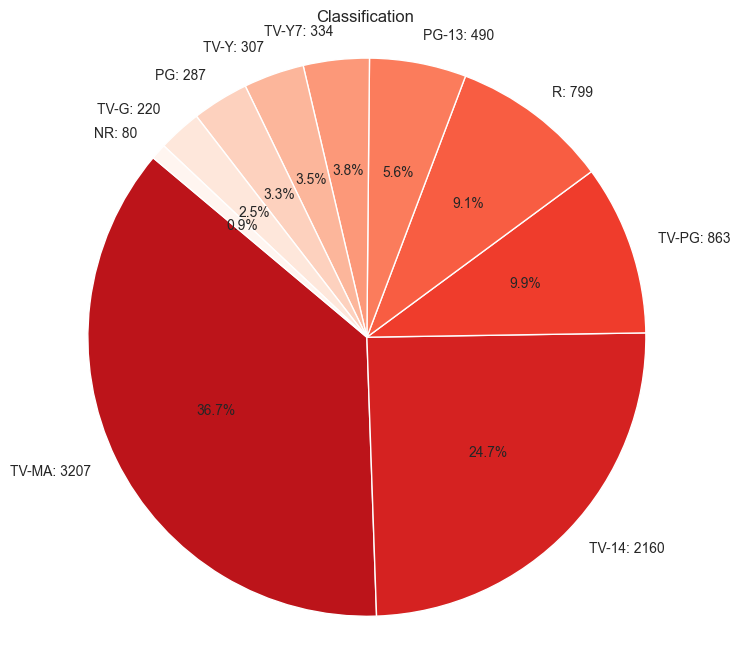

In [76]:
plt.figure(figsize=(8, 8))

cmap = cm.get_cmap('Reds')


plt.pie(rating[:-7], labels=labels[:-7],
        autopct='%1.1f%%',
        startangle=140,
        #colors='Reds',
        colors = cmap(np.linspace(.8, 0, len(rating[:-7]))),
        )
plt.title('Classification')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Duration

## Clean duration data

In [87]:
#From the cells, which are in seasons and minutes, we aim to extract only the number
print(df['duration'].iloc[0], '->',
      re.search('(\d+)', df['duration'].iloc[0]).group(1))
print(df['duration'].iloc[1], '->',
      re.search('(\d+)', df['duration'].iloc[1]).group(1))

90 min -> 90
2 Seasons -> 2


In [88]:
duration_TV_shows = []
duration_movies = []
for i in range(len(df)):
  if df['type'].iloc[i] == 'Movie':
    try:
      duration_movies.append(int(re.search('(\d+)', df['duration'].iloc[i]).group(1)))
    except:
      pass
  elif df['type'].iloc[i] == 'TV Show':
    try:
      duration_TV_shows.append(int(re.search('(\d+)', df['duration'].iloc[i]).group(1)))
    except:
      pass

## plot TV shows season's distribution

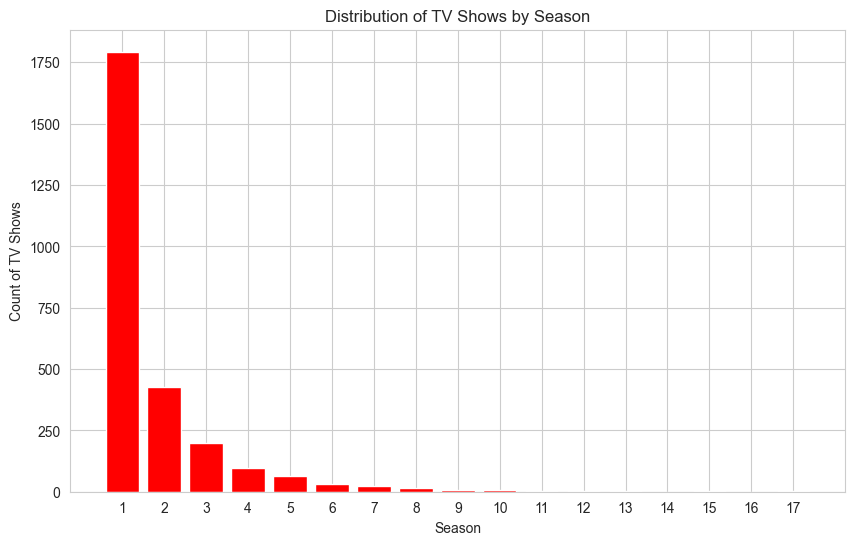

In [113]:
duration_TV_shows_counter = Counter(duration_TV_shows)
data = duration_TV_shows_counter

# Create a list of counts for each season (filling in zeros for missing data)
counts = [data.get(season, 0) for season in range(1, 18)]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(range(1, 18), counts, color='r')
plt.xlabel('Season')
plt.ylabel('Count of TV Shows')
plt.title('Distribution of TV Shows by Season')
plt.grid(True)
plt.xticks(range(1, 18))
plt.show()


## plot duration movies

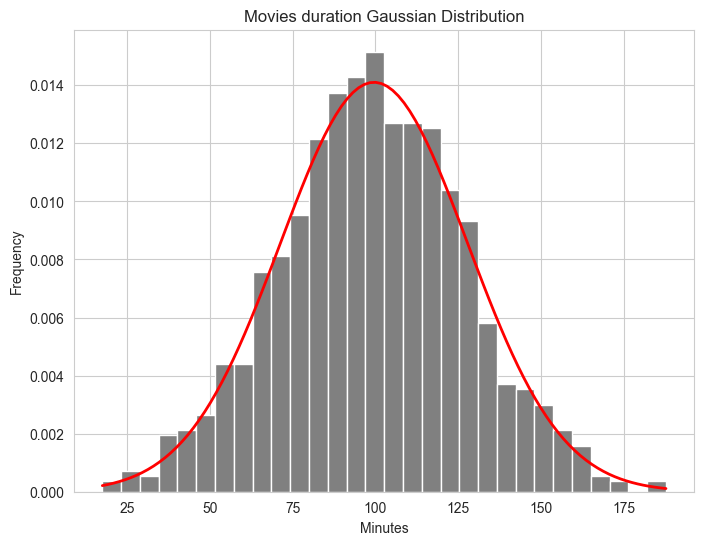

In [104]:
duration_movies = [int(x) for x in duration_movies]
#duration_TV_shows = [int(x) for x in duration_TV_shows if x != '']

data = duration_movies

# Calculate mean and standard deviation of the data
mean = np.mean(data)
std_dev = np.std(data)

# Generate random samples from a Gaussian distribution
gaussian_samples = np.random.normal(mean, std_dev, 1000)

# Plotting the Gaussian distribution
plt.figure(figsize=(8, 6))
plt.hist(gaussian_samples, bins=30, density=True, alpha=1, color='gray')
plt.title('Movies duration Gaussian Distribution')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

# Plotting the Gaussian distribution curve
x = np.linspace(min(gaussian_samples), max(gaussian_samples), 100)
y = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std_dev)**2)  # Gaussian function
plt.plot(x, y, color='red', linewidth=2, label='Gaussian Curve')

plt.grid(True)
plt.show()

# listed_in (category)

In [127]:
category = df['listed_in']
category

0                                           Documentaries
1         International TV Shows, TV Dramas, TV Mysteries
2       Crime TV Shows, International TV Shows, TV Act...
3                                  Docuseries, Reality TV
4       International TV Shows, Romantic TV Shows, TV ...
                              ...                        
8802                       Cult Movies, Dramas, Thrillers
8803               Kids' TV, Korean TV Shows, TV Comedies
8804                              Comedies, Horror Movies
8805                   Children & Family Movies, Comedies
8806       Dramas, International Movies, Music & Musicals
Name: listed_in, Length: 8807, dtype: object

In [128]:
category = [c.split(', ') for c in category if isinstance(c, str)]
category[:2]

[['Documentaries'], ['International TV Shows', 'TV Dramas', 'TV Mysteries']]

In [129]:
total_category = []
for c in category:
  total_category.extend(c)
total_category[:28]

['Documentaries',
 'International TV Shows',
 'TV Dramas',
 'TV Mysteries',
 'Crime TV Shows',
 'International TV Shows',
 'TV Action & Adventure',
 'Docuseries',
 'Reality TV',
 'International TV Shows',
 'Romantic TV Shows',
 'TV Comedies',
 'TV Dramas',
 'TV Horror',
 'TV Mysteries',
 'Children & Family Movies',
 'Dramas',
 'Independent Movies',
 'International Movies',
 'British TV Shows',
 'Reality TV',
 'Comedies',
 'Dramas',
 'Crime TV Shows',
 'Docuseries',
 'International TV Shows',
 'Crime TV Shows',
 'International TV Shows']

In [130]:
sorted(Counter(total_category).items(), key=lambda x: x[1], reverse=True)

[('International Movies', 2752),
 ('Dramas', 2427),
 ('Comedies', 1674),
 ('International TV Shows', 1351),
 ('Documentaries', 869),
 ('Action & Adventure', 859),
 ('TV Dramas', 763),
 ('Independent Movies', 756),
 ('Children & Family Movies', 641),
 ('Romantic Movies', 616),
 ('TV Comedies', 581),
 ('Thrillers', 577),
 ('Crime TV Shows', 470),
 ("Kids' TV", 451),
 ('Docuseries', 395),
 ('Music & Musicals', 375),
 ('Romantic TV Shows', 370),
 ('Horror Movies', 357),
 ('Stand-Up Comedy', 343),
 ('Reality TV', 255),
 ('British TV Shows', 253),
 ('Sci-Fi & Fantasy', 243),
 ('Sports Movies', 219),
 ('Anime Series', 176),
 ('Spanish-Language TV Shows', 174),
 ('TV Action & Adventure', 168),
 ('Korean TV Shows', 151),
 ('Classic Movies', 116),
 ('LGBTQ Movies', 102),
 ('TV Mysteries', 98),
 ('Science & Nature TV', 92),
 ('TV Sci-Fi & Fantasy', 84),
 ('TV Horror', 75),
 ('Anime Features', 71),
 ('Cult Movies', 71),
 ('Teen TV Shows', 69),
 ('Faith & Spirituality', 65),
 ('TV Thrillers', 57),


In [131]:
total_category = [elem.replace(' ', '') for elem in total_category]
total_category

['Documentaries',
 'InternationalTVShows',
 'TVDramas',
 'TVMysteries',
 'CrimeTVShows',
 'InternationalTVShows',
 'TVAction&Adventure',
 'Docuseries',
 'RealityTV',
 'InternationalTVShows',
 'RomanticTVShows',
 'TVComedies',
 'TVDramas',
 'TVHorror',
 'TVMysteries',
 'Children&FamilyMovies',
 'Dramas',
 'IndependentMovies',
 'InternationalMovies',
 'BritishTVShows',
 'RealityTV',
 'Comedies',
 'Dramas',
 'CrimeTVShows',
 'Docuseries',
 'InternationalTVShows',
 'CrimeTVShows',
 'InternationalTVShows',
 'TVAction&Adventure',
 'Dramas',
 'InternationalMovies',
 'Children&FamilyMovies',
 'Comedies',
 'BritishTVShows',
 'CrimeTVShows',
 'Docuseries',
 'TVComedies',
 'TVDramas',
 'Documentaries',
 'InternationalMovies',
 'CrimeTVShows',
 'Spanish-LanguageTVShows',
 'TVDramas',
 'Thrillers',
 'InternationalTVShows',
 'Spanish-LanguageTVShows',
 'TVAction&Adventure',
 'CrimeTVShows',
 'Docuseries',
 'InternationalTVShows',
 'InternationalTVShows',
 'TVAction&Adventure',
 'TVDramas',
 'Comedie

In [132]:
counts_category = sorted(Counter(total_category).items(), key=lambda x: x[1], reverse=True)
counts_category

[('InternationalMovies', 2752),
 ('Dramas', 2427),
 ('Comedies', 1674),
 ('InternationalTVShows', 1351),
 ('Documentaries', 869),
 ('Action&Adventure', 859),
 ('TVDramas', 763),
 ('IndependentMovies', 756),
 ('Children&FamilyMovies', 641),
 ('RomanticMovies', 616),
 ('TVComedies', 581),
 ('Thrillers', 577),
 ('CrimeTVShows', 470),
 ("Kids'TV", 451),
 ('Docuseries', 395),
 ('Music&Musicals', 375),
 ('RomanticTVShows', 370),
 ('HorrorMovies', 357),
 ('Stand-UpComedy', 343),
 ('RealityTV', 255),
 ('BritishTVShows', 253),
 ('Sci-Fi&Fantasy', 243),
 ('SportsMovies', 219),
 ('AnimeSeries', 176),
 ('Spanish-LanguageTVShows', 174),
 ('TVAction&Adventure', 168),
 ('KoreanTVShows', 151),
 ('ClassicMovies', 116),
 ('LGBTQMovies', 102),
 ('TVMysteries', 98),
 ('Science&NatureTV', 92),
 ('TVSci-Fi&Fantasy', 84),
 ('TVHorror', 75),
 ('AnimeFeatures', 71),
 ('CultMovies', 71),
 ('TeenTVShows', 69),
 ('Faith&Spirituality', 65),
 ('TVThrillers', 57),
 ('Movies', 57),
 ('Stand-UpComedy&TalkShows', 56),


## Wordcloud plot

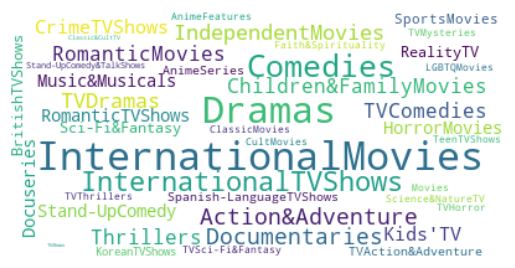

In [133]:
word_list = total_category

# Join the words into a single string separated by spaces
text = ' '.join(word_list)

# Generate a word cloud
wordcloud = WordCloud(background_color='white', max_words  = 42).generate_from_frequencies(Counter(total_category))

# Display the word cloud using matplotlib
plt.figure()#figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()